In [14]:
import torch

if torch.cuda.is_available():
    print("GPU is available!")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    # Để kiểm tra xem một tensor có được tạo trên GPU không
    x = torch.rand(5, 5).cuda()
    print(f"Tensor on GPU: {x.device}")
else:
    print("GPU is NOT available.")

GPU is available!
Number of GPUs: 1
Current GPU: NVIDIA GeForce RTX 3050 Laptop GPU
Tensor on GPU: cuda:0


In [ ]:
from kan import *
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
torch.set_default_dtype(torch.float64)
torch.autograd.set_detect_anomaly(True)


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
df=pd.read_csv('data/origindata.csv')
df.info

<bound method DataFrame.info of        iso_code continent     location        date  total_cases  new_cases   
0           AFG      Asia  Afghanistan  2020-01-05          0.0        0.0  \
1           AFG      Asia  Afghanistan  2020-01-06          0.0        0.0   
2           AFG      Asia  Afghanistan  2020-01-07          0.0        0.0   
3           AFG      Asia  Afghanistan  2020-01-08          0.0        0.0   
4           AFG      Asia  Afghanistan  2020-01-09          0.0        0.0   
...         ...       ...          ...         ...          ...        ...   
429430      ZWE    Africa     Zimbabwe  2024-07-31     266386.0        0.0   
429431      ZWE    Africa     Zimbabwe  2024-08-01     266386.0        0.0   
429432      ZWE    Africa     Zimbabwe  2024-08-02     266386.0        0.0   
429433      ZWE    Africa     Zimbabwe  2024-08-03     266386.0        0.0   
429434      ZWE    Africa     Zimbabwe  2024-08-04     266386.0        0.0   

        new_cases_smoothed  tot

In [18]:
df = df[['new_cases', 'new_deaths','total_cases','handwashing_facilities']]
df=df.dropna()

In [19]:
df = pd.DataFrame(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160689 entries, 0 to 429434
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   new_cases               160689 non-null  float64
 1   new_deaths              160689 non-null  float64
 2   total_cases             160689 non-null  float64
 3   handwashing_facilities  160689 non-null  float64
dtypes: float64(4)
memory usage: 6.1 MB


In [20]:
# X = df.
X = df[['new_deaths','total_cases','handwashing_facilities']]
y = df[['new_cases']]
X.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160689 entries, 0 to 429434
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   new_deaths              160689 non-null  float64
 1   total_cases             160689 non-null  float64
 2   handwashing_facilities  160689 non-null  float64
dtypes: float64(3)
memory usage: 4.9 MB
<class 'pandas.core.frame.DataFrame'>
Index: 160689 entries, 0 to 429434
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   new_cases  160689 non-null  float64
dtypes: float64(1)
memory usage: 2.5 MB


In [21]:
print(X.head())
print(y.head())

   new_deaths  total_cases  handwashing_facilities
0         0.0          0.0                   37.75
1         0.0          0.0                   37.75
2         0.0          0.0                   37.75
3         0.0          0.0                   37.75
4         0.0          0.0                   37.75
   new_cases
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Size of X_train: {X_train.shape}")
print(f"Size of X_test: {X_test.shape}")
print(f"Size of y_train: {y_train.shape}")
print(f"Size of y_test: {y_test.shape}")

Size of X_train: (128551, 3)
Size of X_test: (32138, 3)
Size of y_train: (128551, 1)
Size of y_test: (32138, 1)


In [23]:
print(X.dtypes) # For your features
print(y.dtypes) # For your target (if it's a Pandas Series/DataFrame)

new_deaths                float64
total_cases               float64
handwashing_facilities    float64
dtype: object
new_cases    float64
dtype: object


In [24]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64).to(device) # or torch.long for classification
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64).to(device) 

In [25]:
dataset={}
dataset['train_input'] = X_train_tensor
dataset['test_input'] = X_test_tensor
dataset['train_label'] = y_train_tensor
dataset['test_label'] = y_test_tensor

In [26]:
dataset['train_input'].shape, dataset['train_label'].shape


(torch.Size([128551, 3]), torch.Size([128551, 1]))

In [27]:
print(f"Input has NaN: {torch.isnan(dataset['train_input']).any()}")
print(f"Input has Inf: {torch.isinf(dataset['train_input']).any()}")
print(f"Label has NaN: {torch.isnan(dataset['train_label']).any()}")
print(f"Label has Inf: {torch.isinf(dataset['train_label']).any()}")

Input has NaN: False
Input has Inf: False
Label has NaN: False
Label has Inf: False


In [28]:
grids = np.array([3,10,20])


train_losses = []
test_losses = []
steps = 50
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[dataset['train_input'].shape[1],[3,2],1], grid=grids[i], k=k, seed=1, device=device)
    if i != 0:
        model = model.refine(grids[i])
    results = model.fit(dataset, opt="LBFGS", steps=steps)
    train_losses += results['train_loss']
    test_losses += results['test_loss']

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.92e+05 | test_loss: 1.19e+05 | reg: 3.19e+02 | : 100%|█| 50/50 [05:41<00:00,  6.82s/


saving model version 0.1
saving model version 0.2


| train_loss: 1.46e+05 | test_loss: 6.81e+04 | reg: 4.30e+02 | : 100%|█| 50/50 [04:52<00:00,  5.85s/


saving model version 0.3
saving model version 0.4


| train_loss: 1.37e+05 | test_loss: 7.40e+04 | reg: 4.82e+02 | : 100%|█| 50/50 [07:50<00:00,  9.41s/

saving model version 0.5


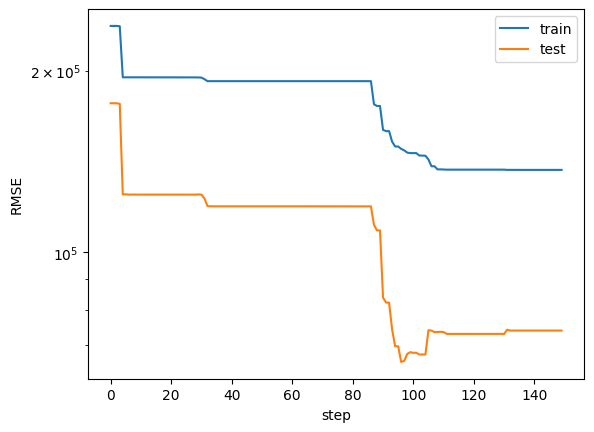

In [29]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

Text(0, 0.5, 'RMSE')

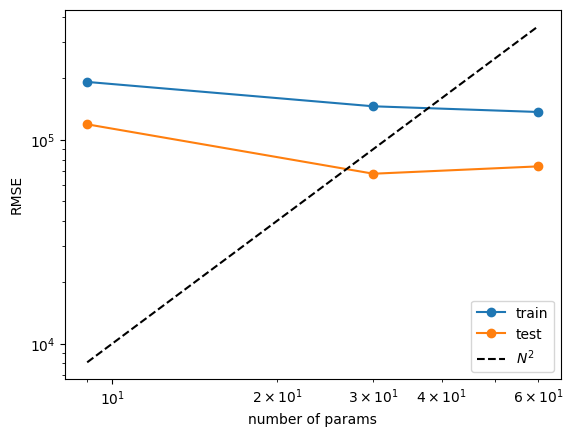

In [37]:
n_params = 3 * grids
train_vs_G = train_losses[(steps-1)::steps]
test_vs_G = test_losses[(steps-1)::steps]
plt.plot(n_params, train_vs_G, marker="o")
plt.plot(n_params, test_vs_G, marker="o")
plt.plot(n_params, 100*n_params**(2.), ls="--", color="black")
plt.xscale('log')
plt.yscale('log')
plt.legend(['train', 'test', r'$N^{2}$'])
plt.xlabel('number of params')
plt.ylabel('RMSE')

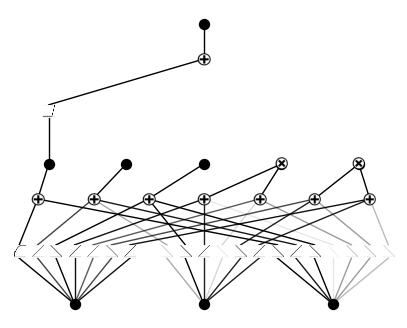

In [41]:
model.plot(metric='forward_n')


In [40]:
model.feature_score


tensor([0.2344, 0.2009, 0.9585], device='cuda:0', grad_fn=<MeanBackward1>)